# Sentiment Analysis using BERT

This notebook performs sentiment analysis using an LSTM model on a Twitter dataset.

In [8]:
!pip install transformers

In [9]:
pip install huggingface_hub[hf_xet]

Note: you may need to restart the kernel to use updated packages.


In [115]:
import pandas as pd
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel

import torch
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

In [117]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load and Preprocess the Data

In [119]:
# Preprocessing function
def preprocess(text):
    text = re.sub(r"http\S+|@\S+|#[A-Za-z0-9]+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower()
    return " ".join([word for word in text.split() if word not in stop_words])

In [121]:
# Load dataset
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv(r"C:\Users\LENOVO\OneDrive\AICTE\Sentimental Analysis\datasets\training.1600000.processed.noemoticon.csv",
                 encoding='latin-1', 
                 names=columns,
                 low_memory=False,
                 skiprows=1)
df = df[['target', 'text']]
df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
df['clean_text'] = df['text'].apply(preprocess)

In [123]:
# Use sample for speed
df_sample = df.sample(n=5000, random_state=42)
X = df_sample['clean_text']
y = df_sample['target']

## Tokenization and Padding

In [125]:
# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

In [127]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

In [129]:
# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## Evaluate the Model

In [131]:
# Evaluate
train_acc = clf.score(X_train, y_train)
val_acc = clf.score(X_val, y_val)

In [133]:
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Training Accuracy: 0.8243
Validation Accuracy: 0.7750


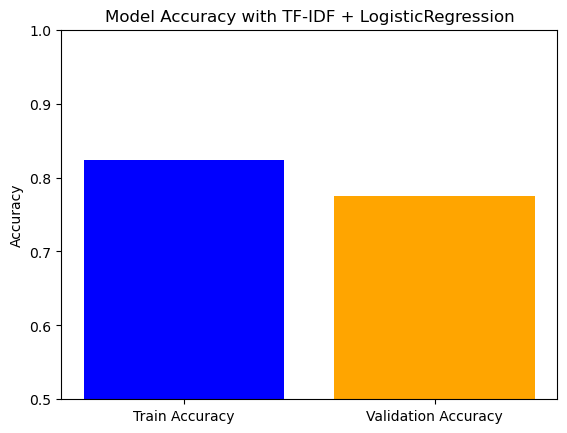

In [135]:
# Plot accuracy
plt.bar(['Train Accuracy', 'Validation Accuracy'], [train_acc, val_acc], color=['blue', 'orange'])
plt.title('Model Accuracy with TF-IDF + LogisticRegression')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.show()

In [137]:
# Save model and vectorizer
with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(clf, f)
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

In [139]:
# BERT embeddings extractor (not used for training in this version)
def get_bert_embeddings(text_list):
    embeddings = []
    for text in tqdm(text_list):
        clean_text = preprocess(text)
        inputs = tokenizer(clean_text, return_tensors='pt', truncation=True, padding=True, max_length=128)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embedding)
    return np.array(embeddings)

In [141]:
# Prediction function using trained TF-IDF + LR
def predict_sentiment(texts, model, vectorizer):
    clean_texts = [preprocess(text) for text in texts]
    X_vec = vectorizer.transform(clean_texts)
    preds = model.predict(X_vec)
    return ['Positive' if p > 0 else 'Negative' for p in preds]

In [143]:
texts = ["I love this product!", "This is awful."]
results = predict_sentiment(texts, clf, vectorizer)
print(results)

['Positive', 'Negative']
